In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
%config InlineBackend.figure_format = "retina"

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Data

In [2]:
!cat data/breast-cancer-wisconsin.names

Citation Request:
   This breast cancer databases was obtained from the University of Wisconsin
   Hospitals, Madison from Dr. William H. Wolberg.  If you publish results
   when using this database, then please include this information in your
   acknowledgements.  Also, please cite one or more of:

   1. O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear 
      programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

   2. William H. Wolberg and O.L. Mangasarian: "Multisurface method of 
      pattern separation for medical diagnosis applied to breast cytology", 
      Proceedings of the National Academy of Sciences, U.S.A., Volume 87, 
      December 1990, pp 9193-9196.

   3. O. L. Mangasarian, R. Setiono, and W.H. Wolberg: "Pattern recognition 
      via linear programming: Theory and application to medical diagnosis", 
      in: "Large-scale numerical optimization", Thomas F. Coleman and Yuying
      Li, editors, SIAM Publications, Philadelphia 199

## Read CSV

In [3]:
df = pd.read_csv("data/breast-cancer-wisconsin.data", header=None, index_col=0, na_values="?")
df = df.dropna()  # Drop rows with nulls
df = df.replace({10: {2: 0, 4: 1}})  # Set binary target to 0/1
df

,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
1000025,5,1,1,1,2,1.0,3,1,1,0
1002945,5,4,4,5,7,10.0,3,2,1,0
1015425,3,1,1,1,2,2.0,3,1,1,0
1016277,6,8,8,1,3,4.0,3,7,1,0
1017023,4,1,1,3,2,1.0,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
776715,3,1,1,1,3,2.0,1,1,1,0
841769,2,1,1,1,2,1.0,1,1,1,0
888820,5,10,10,3,7,3.0,8,10,2,1


## Create X and y

In [4]:
X = torch.from_numpy(df.values).float()
X

tensor([[ 5.,  1.,  1.,  ...,  1.,  1.,  0.],
        [ 5.,  4.,  4.,  ...,  2.,  1.,  0.],
        [ 3.,  1.,  1.,  ...,  1.,  1.,  0.],
        ...,
        [ 5., 10., 10.,  ..., 10.,  2.,  1.],
        [ 4.,  8.,  6.,  ...,  6.,  1.,  1.],
        [ 4.,  8.,  8.,  ...,  4.,  1.,  1.]])

In [5]:
X, y = X[:, :-1], X[:, -1]
X = torch.hstack((X, torch.ones((len(X), 1))))  # Augment with a column of 1s for the intercept

In [6]:
X

tensor([[ 5.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 5.,  4.,  4.,  ...,  2.,  1.,  1.],
        [ 3.,  1.,  1.,  ...,  1.,  1.,  1.],
        ...,
        [ 5., 10., 10.,  ..., 10.,  2.,  1.],
        [ 4.,  8.,  6.,  ...,  6.,  1.,  1.],
        [ 4.,  8.,  8.,  ...,  4.,  1.,  1.]])

# Training
https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [7]:
def gradient_descent(iterations, learning_rate=.1):
    """Run gradient descent for multiple iterations and return y_pred for each iteration"""
    # Initialize w
    torch.manual_seed(0)
    w = nn.Parameter(torch.randn(X.shape[1]))
    
    # Run gradient descent
    y_preds = []
    for _ in range(iterations):
        y_pred = torch.sigmoid(X @ w)
        y_preds.append(y_pred.detach())
        loss = nn.BCELoss()(y_pred, y)
        loss.backward()
        with torch.no_grad():
            w.sub_(learning_rate * w.grad)
            w.grad.zero_()
    return y_preds

scikit-learn: loss=0.0753207728266716, auc=0.9963247766595047


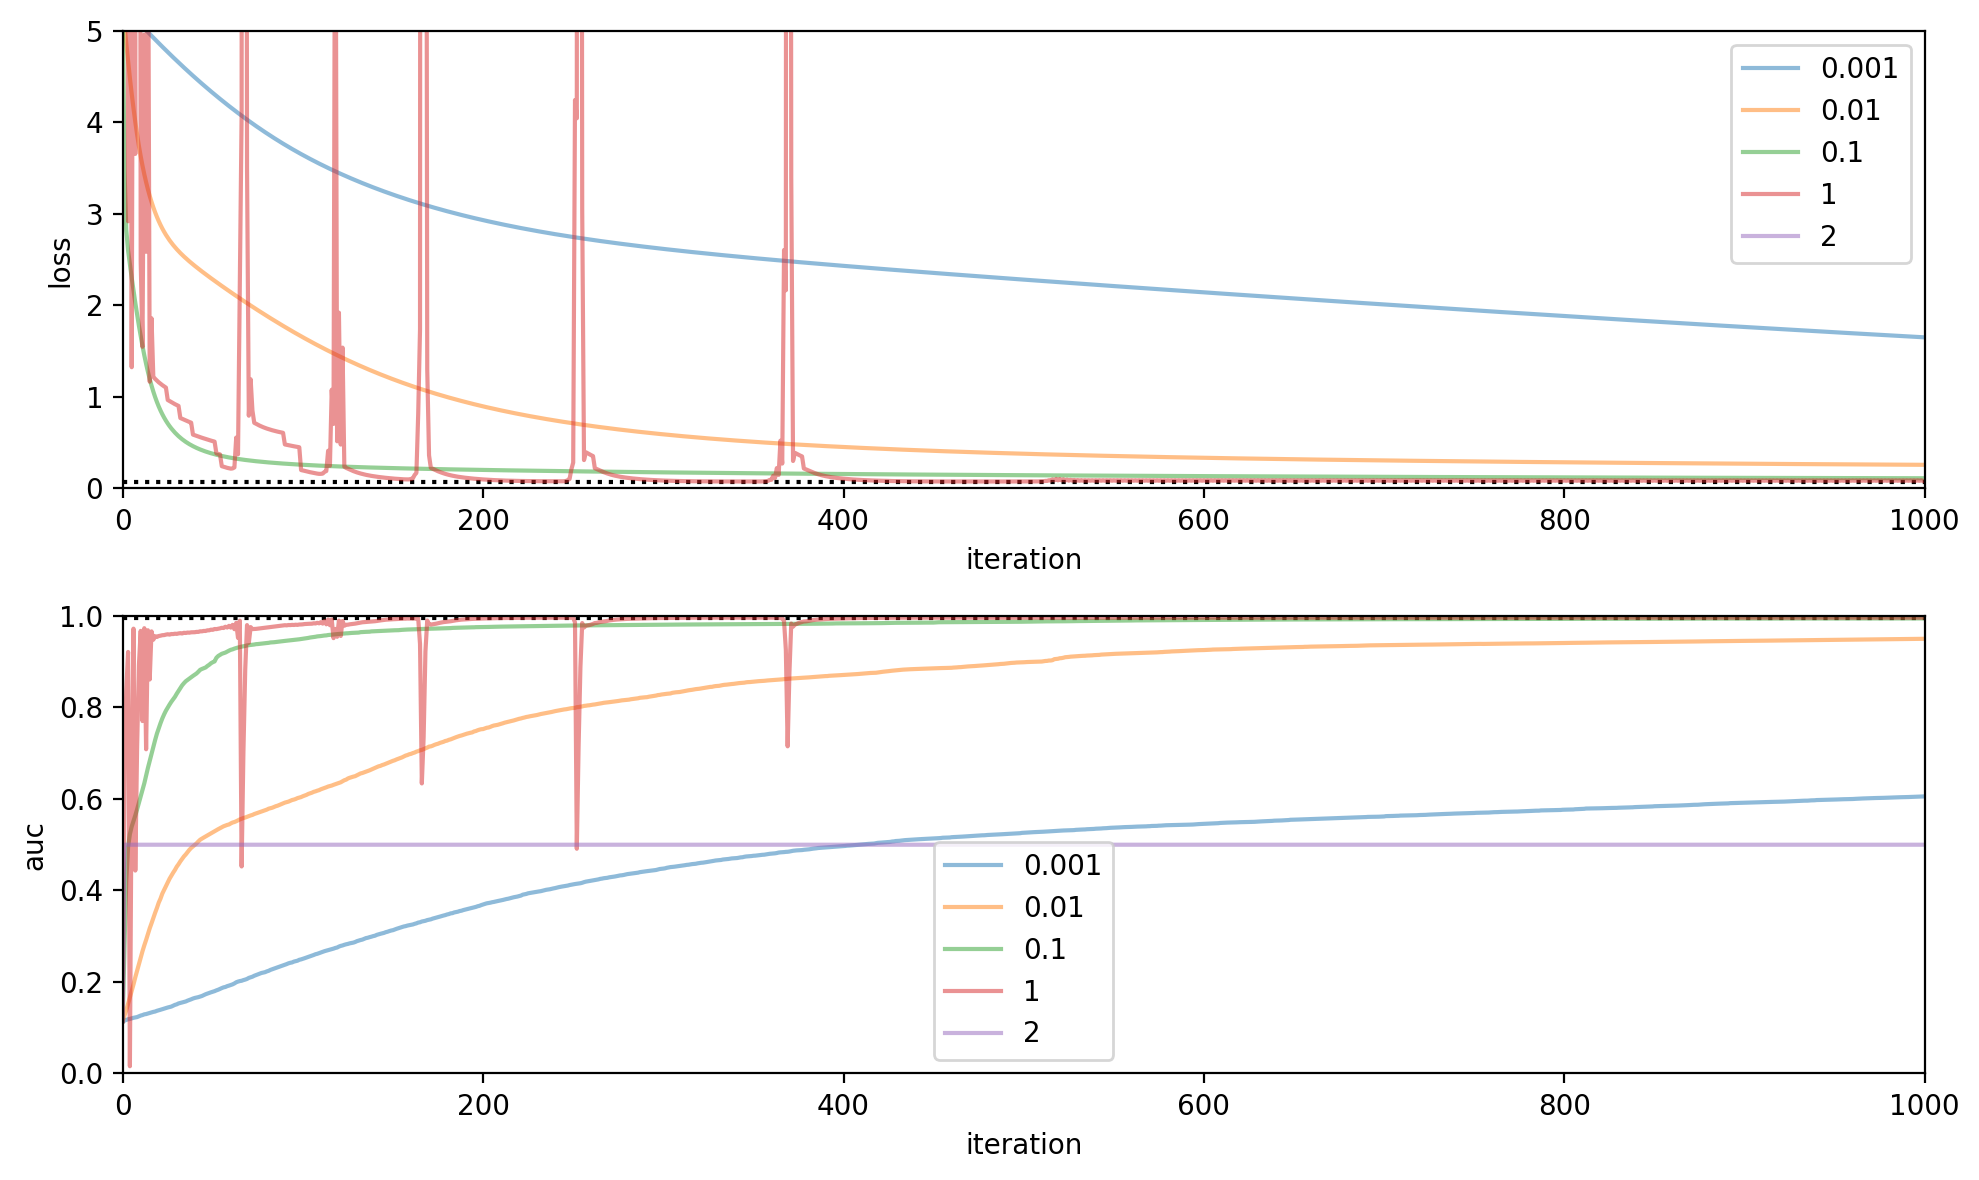

In [8]:
ITERATIONS = 1000
LEARNING_RATES = [.001, .01, .1, 1, 2]

fig, axes = plt.subplots(nrows=2, figsize=(10, 6), tight_layout=True)
axes[0].set(xlabel="iteration", xlim=(0, ITERATIONS), ylabel="loss", ylim=(0, 5))
axes[1].set(xlabel="iteration", xlim=(0, ITERATIONS), ylabel="auc", ylim=(0, 1))

# Plot scikit-learn performance
y_pred = LogisticRegression(penalty=None).fit(X, y).predict_proba(X)[:, 1]
loss = nn.BCELoss()(torch.from_numpy(y_pred).float(), y)
auc = roc_auc_score(y, y_pred)
print(f"scikit-learn: loss={loss}, auc={auc}")
axes[0].axhline(loss, c="k", ls=":")
axes[1].axhline(auc, c="k", ls=":")

# Plot performance of different learning rates
for learning_rate in LEARNING_RATES:
    y_preds = gradient_descent(iterations=ITERATIONS, learning_rate=learning_rate)
    losses = [nn.BCELoss()(y_pred, y) for y_pred in y_preds]
    aucs = [roc_auc_score(y, y_pred.detach()) for y_pred in y_preds]
    axes[0].plot(losses, alpha=.5, label=learning_rate)
    axes[1].plot(aucs, alpha=.5, label=learning_rate)
axes[0].legend()
axes[1].legend();